Importing necessary packages

In [1]:
# Common
import numpy as np
import re
import tensorflow as tf
import pickle

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Data collection
import pandas as pd

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
from keras import backend as K
from keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve

# Data/Result visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

2024-02-07 00:03:58.709846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 00:03:58.709938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 00:03:58.846430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Reading train and test datasets

In [2]:
train = pd.read_csv("./Data/train.csv")
test  = pd.read_csv("./Data/test.csv")

# Preview of training data sample
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


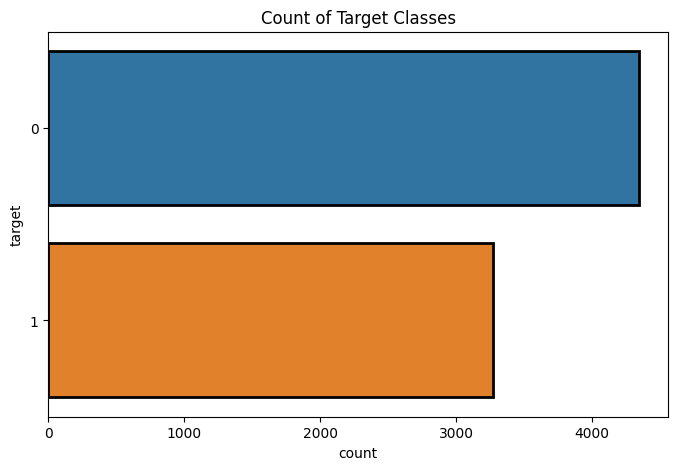

In [3]:
# Visualizing the target classes
plt.figure(figsize=(8,5))
plt.title("Count of Target Classes")
sns.countplot(y=train["target"],linewidth=2,
                   edgecolor='black')

plt.show()

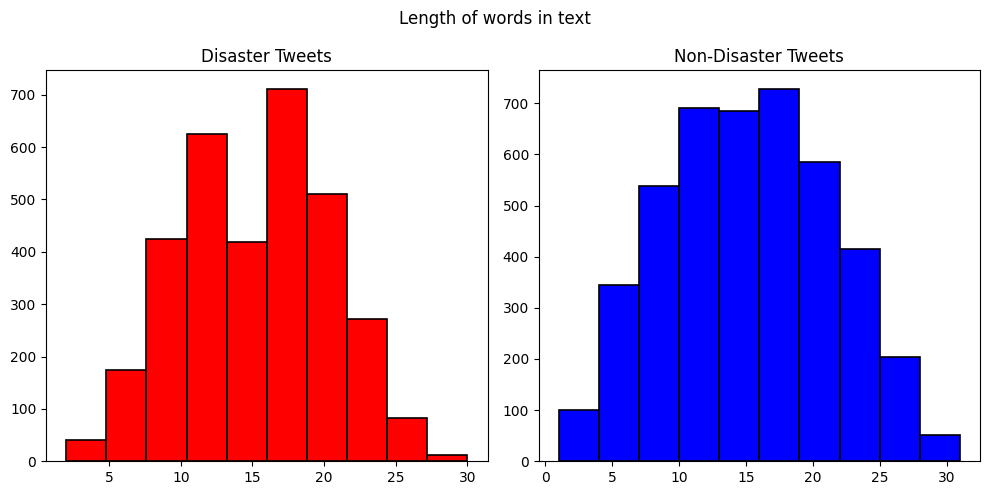

In [4]:
# Analysing number of words in text.
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')
char_len_ndis = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')
plt.suptitle("Length of words in text")
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


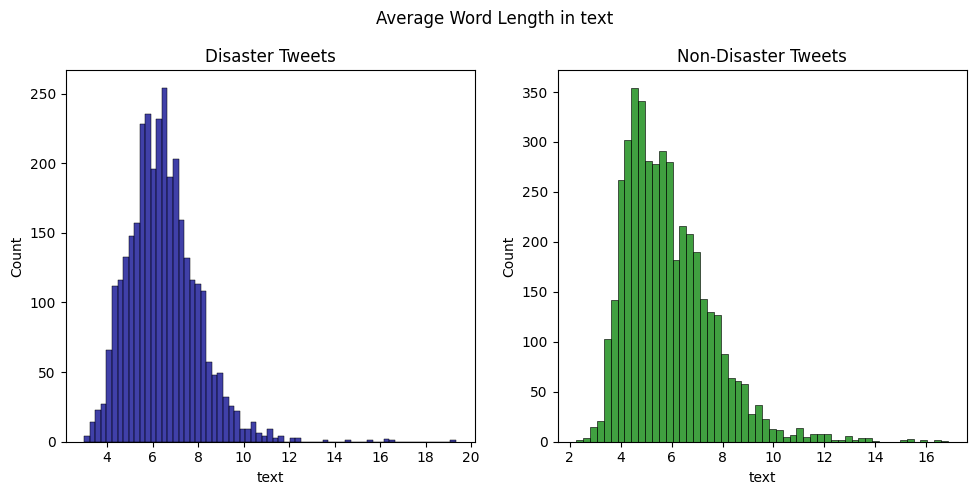

In [5]:
# Analysing average word length in text.
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Disaster Tweets')
char_len_ndis = train[train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(char_len_ndis.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Non-Disaster Tweets')
plt.suptitle("Average Word Length in text")
plt.tight_layout()
plt.show()

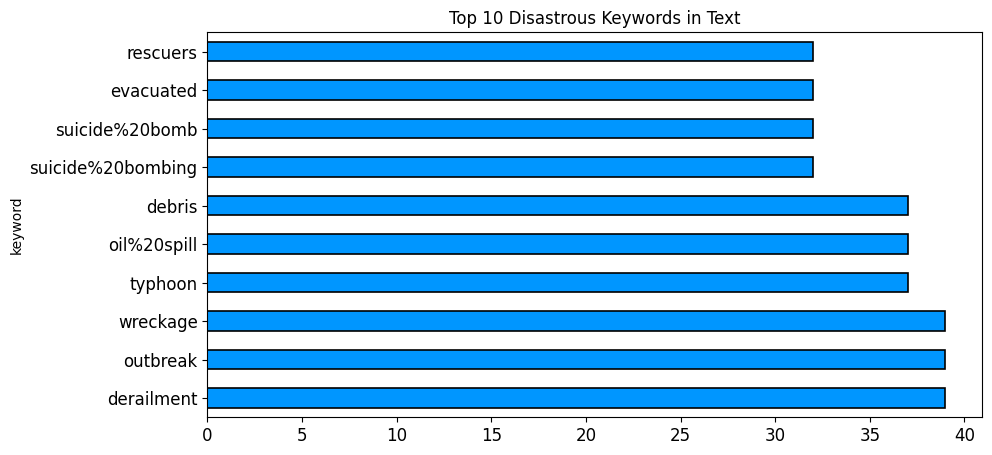

In [6]:
# Analysing Top 20  disastrous KeyWords in text .
plt.figure(figsize=(10,5))
train[train['target']==1]['keyword'].value_counts()[:10].plot(kind='barh', fontsize=12,title='Top 10 Disastrous Keywords in Text', color='#0096FF',edgecolor='black', linewidth=1.2)
plt.show()

Data Preprocessing

Function for expanding abbrebiations

In [7]:
def deabbreviate(text):
    text = text.upper()
    text = re.sub(r'bAFAIKb', ' As Far As I Know ',text)
    text = re.sub(r'bAFKb', ' From Keyboard ',text)
    text = re.sub(r'bASAPb', ' As Soon As Possible ',text)
    text = re.sub(r'bATKb', ' At The Keyboard ',text)
    text = re.sub(r'bA3b', ' Anytime, Anywhere, Anyplace ',text)
    text = re.sub(r'bBAKb', ' Back At Keyboard ',text)
    text = re.sub(r'bBBLb', ' Be Back Later ',text)
    text = re.sub(r'bBBSb', ' Be Back Soon ',text)
    text = re.sub(r'bBFNb', ' Bye For Now ',text)
    text = re.sub(r'bBRBb', ' Be Right Back ',text)
    text = re.sub(r'bBRTb', ' Be Right There ',text)
    text = re.sub(r'bBTWb', ' By The Way ',text)
    text = re.sub(r'bB4b', ' Before ',text)
    text = re.sub(r'bB4Nb', ' Bye For Now ',text)
    text = re.sub(r'bCUb', ' See You ',text)
    text = re.sub(r'bCUL8Rb', ' See You Later ',text)
    text = re.sub(r'bCYAb', ' See You ',text)
    text = re.sub(r'bFAQb', ' Frequently Asked Questions ',text)
    text = re.sub(r'bFYIb', ' For Your Information ',text)
    text = re.sub(r'bGNb', ' Good Night ',text)
    text = re.sub(r'bGR8b', ' Great ',text)
    text = re.sub(r'bICb', ' I See ',text)
    text = re.sub(r'bLOLb', ' Laughing Out Loud ',text)
    text = re.sub(r'bL8Rb', ' Later ',text)
    text = re.sub(r'bM8b', ' Mate ',text)
    text = re.sub(r'bTHXb', ' Thank You ',text)
    text = re.sub(r'bTTFNb', ' BYE ',text)
    text = re.sub(r'bTTFNb', ' BYE ',text)
    text = re.sub(r'bUb', ' You ',text)
    text = re.sub(r'bU2b', ' You TOO ',text)
    text = re.sub(r'bWTFb', ' What The Heck ',text)
    text = re.sub(r'bW8b', ' Wait ',text)
    text = re.sub(r'bFAVb', ' Favourite ',text)
    text = re.sub(r'bHWYb'," highway ",text)
    text = re.sub(r'bPPLb'," people ",text)
    text = re.sub(r'bGVb'," give ",text)
    text = re.sub(r'bWANNAb'," want to ",text)
    text = text.lower()
    return text

Functions to convert string to ascii string

In [8]:
def return_ascii(text):
    ret_str = ""
    for char in list(text):
        if char.isascii():
            ret_str += char
    return ret_str

Preparing variables for preprocessing text

In [9]:
nltk.download(['stopwords', 'wordnet'])
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
punctuations = '!"#$%&()\'*+,-./:;?@[]^_`{|}~'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

Function to clean text

In [11]:

def preprocess(text):
    #1.Removing AM and PM
    text = re.sub(r'b[AP]{1}Mb'," ",text)
    #2.Lowercasing
    text = text.lower()
    #3.removing mentions
    text =re.sub(r'@[^ ]+',' ',text)
    #4.removing urls
    text = re.sub(r'https*://t.co/w+',' ',text)
    text = re.sub(r'https*://[^ ]+',' ',text)
    #5.De-abbreviating
    text = deabbreviate(text)
    #6.cleaning mscl
    text = re.sub(r"åê"," ",text)
    text = re.sub(r'&[^ ]+'," ",text)
    text = re.sub(r'b[a-z]+-[0-9]+b'," ",text)
    text = re.sub(r'bd+[a-z]+d+b'," ",text)
    text = re.sub(r'brtb'," ",text)
    text = re.sub(r'bfavb'," ",text)
    text = re.sub(r'b[h]{1}a[ha]+b',"haa",text)
    text = re.sub(r'b[a-z]+d+[a-z]+b'," ",text)
    #7.removing months
    text = re.sub(r" jan | feb | mar | apr | may | jun | jul | aug | sep | oct | nov | dec ",' ',text)
    #8.decontracting
    text = re.sub(r"aren't",'are not',text)
    text = re.sub(r"won't",' will not ',text)
    text = re.sub(r"bi'mb",' I am ',text)
    text = re.sub(r"bi'db",' I would ',text)
    text = re.sub(r"bit'sb",' it is ',text)
    text = re.sub(r"bthat'sb",' that is ',text)
    text = re.sub(r"bcan'tb",' can not ',text)
    text = re.sub(r"bi'veb",' I have ',text)
    text = re.sub(r"bthere'sb",' there is ',text)
    text = re.sub(r"bdidn'tb",' did not ',text)
    text = re.sub(r"bcouldn'tb",' could not ',text)
    text = re.sub(r"bisn'tb",' is not ',text)
    text = re.sub(r"bwe'reb", ' we are ',text)
    text = re.sub(r"bthey'reb",' they are ',text)
    text = re.sub(r"bdon'tb",' do not ',text)
    text = re.sub(r"blet'sb",' let us ',text)
    text = re.sub(r"bli'lb",' little ',text)
    text = re.sub(r"bshe'sb",' she is ',text)
    text = re.sub(r"bhe'sb",' he is ',text)
    text = re.sub(r"bhow'reb",' How are ',text)
    text = re.sub(r"wasn't",' was not ',text)
    text = re.sub(r"bwhat'sb",' what is ',text)
    text = re.sub(r"bhe'llb",' he will ',text)
    text = re.sub(r"bi'llb",' i will ',text)
    text = re.sub(r"bshe'llb",' she will ',text)
    text = re.sub(r"byou'llb",' you will ',text)
    text = re.sub(r"byou'reb",' you are ',text)
    text = re.sub(r"bwe'veb",' we have ',text)
    text = re.sub(r"byou'veb",' you have ',text)
    text = re.sub(r"bthey'veb",' they have ',text)
    #10.Removing the punctuations
    for p in punctuations:
        text = text.replace(p,"   ")
    #11.removing certain patters
    text = re.sub(r'lo+l',"laughing out loud",text)
    text = re.sub(r'coo+l',"cool",text)
    text = re.sub(r'go+a+l+','goal',text)
    text = re.sub(r'so+',"so",text)
    text = re.sub(r'bo+h+o*b','oh',text)
    #12.Removing the digits
    text = re.sub(r'\d+'," ",text)
    #13.New line as space
    text = re.sub(r'\n'," ",text)
    #14.Removing extra spaces
    text = re.sub(r'[ ]+'," ",text)
    #15.Stripping the end parts
    text = text.strip()
    #16.removing the accents
    text = return_ascii(text)
    #17.removing certain patterns after getting only the ascii characters
    text = re.sub(r"bcantb",' can not ',text)
    text = re.sub(r"bwontb",' will not ',text)
    text = re.sub(r"bimb",' I am ',text)
    text = re.sub(r"bdidntb",' did not ',text)
    text = re.sub(r"bcouldntb",' could not ',text)
    text = re.sub(r"bisntb",' is not ',text)
    text = re.sub(r"bdontb",' do not ',text)
    text = re.sub(r"blilb",' little ',text)
    text = re.sub(r"balilb",' a little ',text)
    text = re.sub(r"view and download video",' ',text)
    text = re.sub(r"bviaZ",' ',text)
    #18.Removing words with lengths less than 2
    text = [ele for ele in text.split(" ") if len(ele) > 1 ]
    text = " ".join(text)
    #19.Removing emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    #20.Removing stopwords
    text = [word for word in text.split() if word not in sw]
    #21.Lemmatizing each word in the text
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

Applying preprocessings to training dataset

In [12]:
train['text'] = train['text'].apply(preprocess)

Dropping rows that have null text values after preprocessing

In [13]:
train.dropna(subset=['text'],inplace=True)

Dropping duplicate data with ambiguous target labels

In [14]:
df_dup = train[train['text'].duplicated()]
text_arr = np.unique(df_dup['text'].values)
df_dup = train[train['text'].isin(text_arr)].sort_values(by=['text'])
df_dup = df_dup[~df_dup.duplicated()].sort_values(by=['text'])
df_dup_contradiction = df_dup[df_dup['text'].duplicated()]
df_dedup = train.drop_duplicates(subset=['text'])
df_dedup = df_dedup[~df_dedup['text'].isin(df_dup_contradiction['text'].values)]

In [15]:
df_dedup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6459 entries, 0 to 7606
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6459 non-null   int64 
 1   keyword   6409 non-null   object
 2   location  4357 non-null   object
 3   text      6459 non-null   object
 4   target    6459 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 302.8+ KB


WordCloud for positively labeled data(Disaster)

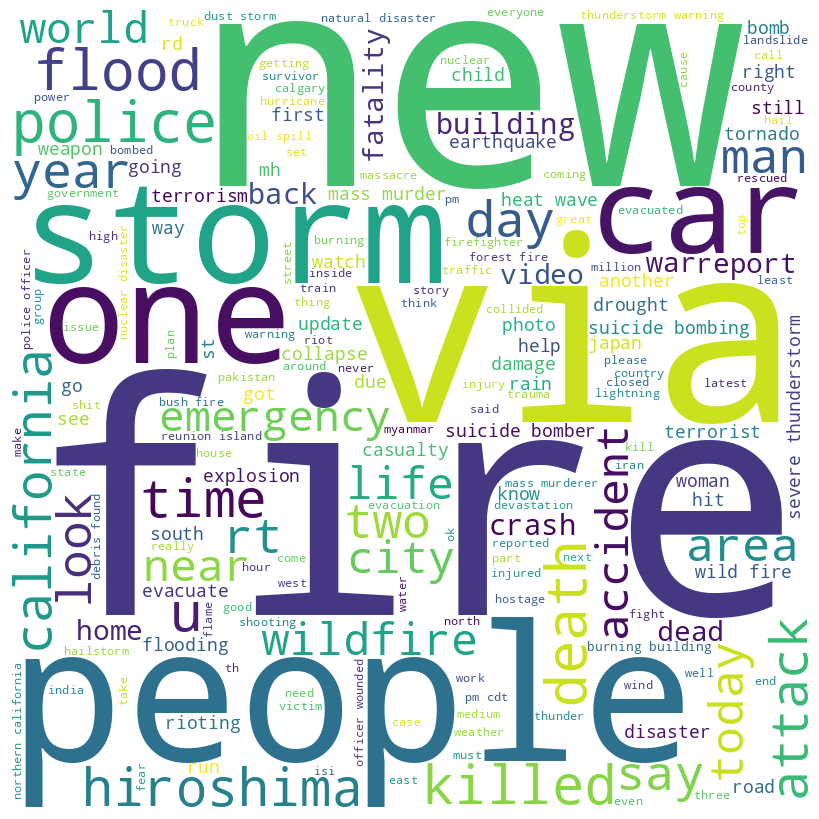

In [16]:
positive_sentences = ""
for sentence in df_dedup[df_dedup['target'] == 1]['text'].tolist():
    positive_sentences = positive_sentences + " "+sentence
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_sentences)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

WordCloud for negatively labeled data (Not disaster)

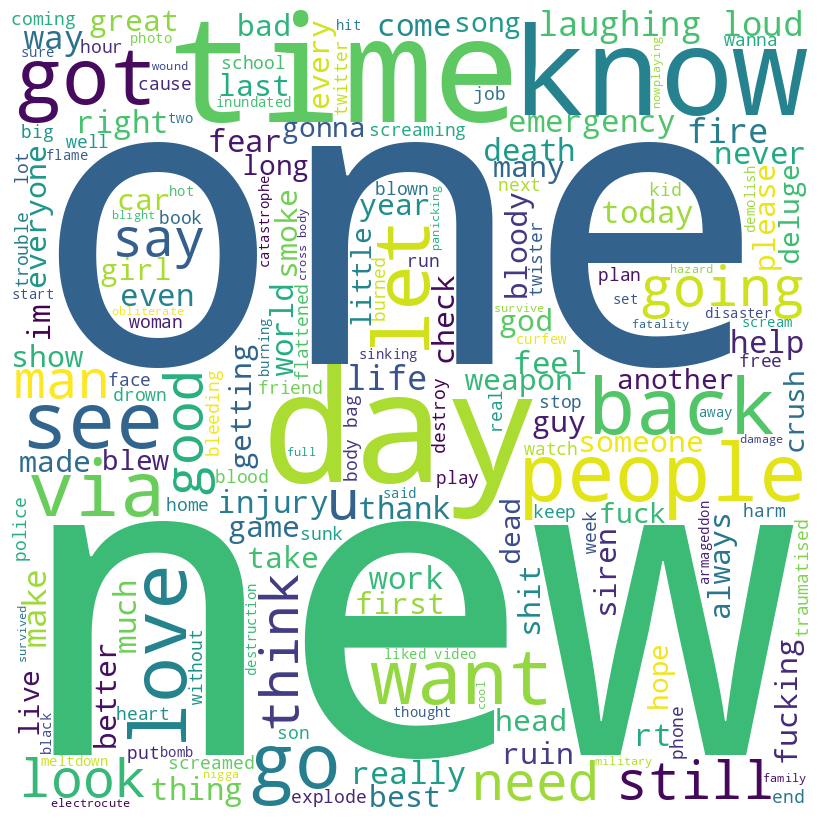

In [17]:
negative_sentences = ""
for sentence in df_dedup[df_dedup['target'] == 0]['text'].tolist():
    negative_sentences = negative_sentences + " "+sentence
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_sentences)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Preparing data for training

In [18]:
# Maximum number of words that the embedding will have
MAX_NUM_WORDS = 50000
# Size of dimension that embedding layer will use
EMBEDDING_DIM = 100
# Maximum number of words that each tweet will have
MAX_SEQUENCE_LENGTH = 100

Defining utility functions for tokenizer

In [19]:
def create_tokenizer(input_data, save_path):
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS,
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
    lower=True)
  tokenizer.fit_on_texts(input_data)
  save_tokenizer(tokenizer, save_path)
  return tokenizer

# Saves tokenizer in file system with a given name
def save_tokenizer(tokenizer, filename):
  with open(filename, 'wb') as f:
    pickle.dump(tokenizer, f,
    protocol=pickle.HIGHEST_PROTOCOL)

# Loads tokenizer object from filesystem by filename
def load_tokenizer(filename):
  with open(filename, 'rb') as f:
    tokenizer = pickle.load(f)
    return tokenizer

Defining a function for transforming an array of texts into embeddings

In [20]:
def transform_text(tokenizer, texts):
  # Transform texts into embedding vectors with a given tokenizer
  sequences = tokenizer.texts_to_sequences(texts)
  # Left padding each vector with zeros to match lengths of all vectors
  return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [21]:
train = df_dedup
# Create tokenizer
tokenizer = create_tokenizer(train['text'].values, 'disaster_tokenizer.pickle')
# Obtain embeddings for training data
X = transform_text(tokenizer, train['text'].values)
# Getting training labels
Y = train['target'].values.astype('int')
# Splitting the training dataset into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42, stratify=Y)

Defining metric functions

In [22]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

Building the LSTM model

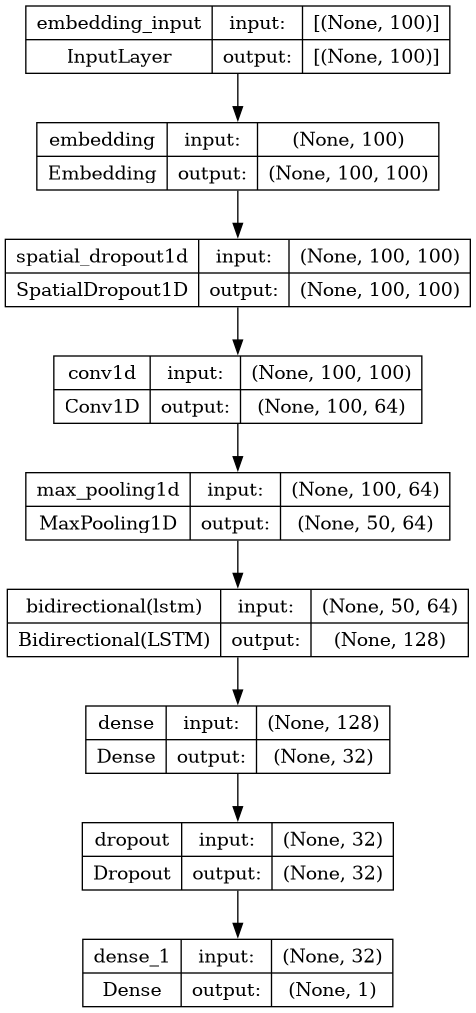

In [23]:
model = Sequential()
# Adam optimizer with learning rate of 0.00005
optimizer = tf.keras.optimizers.Adam(5e-5)
# Embedding layer
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM,
  input_length=MAX_SEQUENCE_LENGTH))
# Dropout
model.add(SpatialDropout1D(0.2))
# Convolutional layer with kernel size 3
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# Max pooling layer to reduce neuron size
model.add(MaxPooling1D(pool_size=2))
# Bidirectional LSTM with 64 units with dropout and L1L2 regularization
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3,
               kernel_regularizer= L1L2(l1=0.01, l2=0.0))))
# Dense layer
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
# Binary output layer with sigmoid function
model.add(Dense(1, activation='sigmoid'))

# Using binary crossentropy loss function
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_m, precision_m, recall_m, specificity_m])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Training the model

In [24]:
epochs = 20
batch_size = 32
# Callback for stopping training when validation loss converges or drops during training
es = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-5, restore_best_weights=True, mode='min')
# Callback for reducing learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                              verbose=1, mode='min')
# Training on train data and getting training history object
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, Y_val), callbacks=[es, reduce_lr], shuffle=True)
# Saving model in file system
model.save('disaster_model.keras')

Epoch 1/20


I0000 00:00:1707264290.224964     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 [==============================] - 61s 304ms/step - loss: 21.7793 - accuracy: 0.6002 - f1_m: 0.0024 - precision_m: 0.0154 - recall_m: 0.0013 - specificity_m: 0.9988 - val_loss: 20.4853 - val_accuracy: 0.5998 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_specificity_m: 1.0000 - lr: 5.0000e-05
Epoch 2/20
162/162 [==============================] - 41s 251ms/step - loss: 19.2746 - accuracy: 0.6002 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - specificity_m: 1.0000 - val_loss: 18.0687 - val_accuracy: 0.5998 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_specificity_m: 1.0000 - lr: 5.0000e-05
Epoch 3/20
162/162 [==============================] - 40s 245ms/step - loss: 16.9383 - accuracy: 0.6002 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - specificity_m: 1.0000 - val_loss: 15.8133 - val_accuracy: 0.5998 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - v

Defining a function for plotting graphs of loss and f1 scores of training history

In [25]:
def plot_model_hist(history):
    # Plotting train and validation loss graph
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'],
    label='test')
    plt.legend()
    plt.savefig('loss_graph.png')
    plt.show()

    # Plotting train and validation accuracy graph
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'],
    label='test')
    plt.legend()
    plt.savefig('acc_graph.png')
    plt.show()
    
    # Plotting train and validation recall graph
    plt.title('Recall')
    plt.plot(history.history['recall_m'], label='train')
    plt.plot(history.history['val_recall_m'],
    label='test')
    plt.legend()
    plt.savefig('recall_graph.png')
    plt.show()
    
    # Plotting train and validation precision graph
    plt.title('Precision')
    plt.plot(history.history['precision_m'], label='train')
    plt.plot(history.history['val_precision_m'],
    label='test')
    plt.legend()
    plt.savefig('precision_graph.png')
    plt.show()

    # Plotting train and validation specificity graph
    plt.title('Specificity')
    plt.plot(history.history['specificity_m'], label='train')
    plt.plot(history.history['val_specificity_m'],
    label='test')
    plt.legend()
    plt.savefig('specificity_graph.png')
    plt.show()

    # Plotting train and validation F1 score graph
    plt.title('F1 score')
    plt.plot(history.history['f1_m'], label='train')
    plt.plot(history.history['val_f1_m'],
    label='test')
    plt.legend()
    plt.savefig('f1_graph.png')
    plt.show()

Inference on validation set

41/41 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       775
           1       0.74      0.70      0.72       517

    accuracy                           0.78      1292
   macro avg       0.78      0.77      0.77      1292
weighted avg       0.78      0.78      0.78      1292



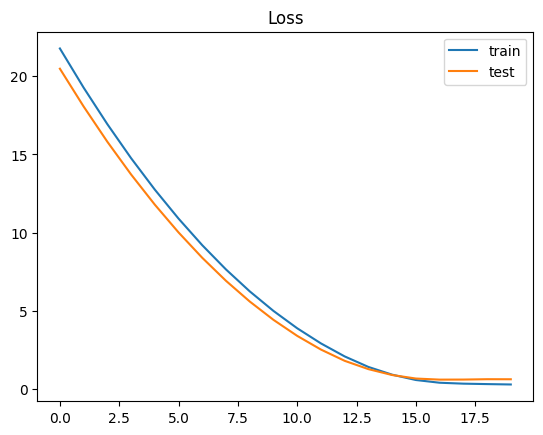

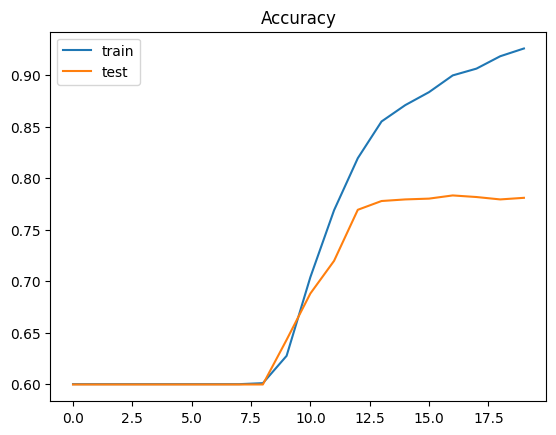

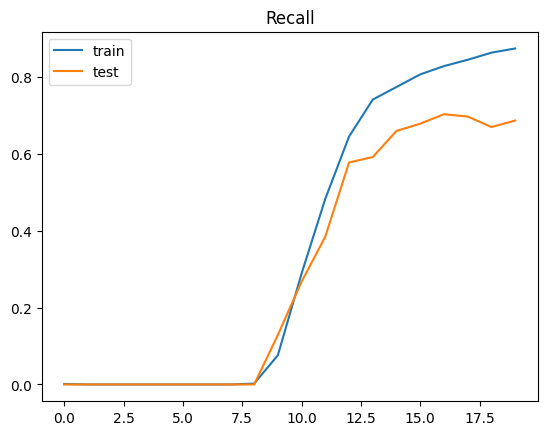

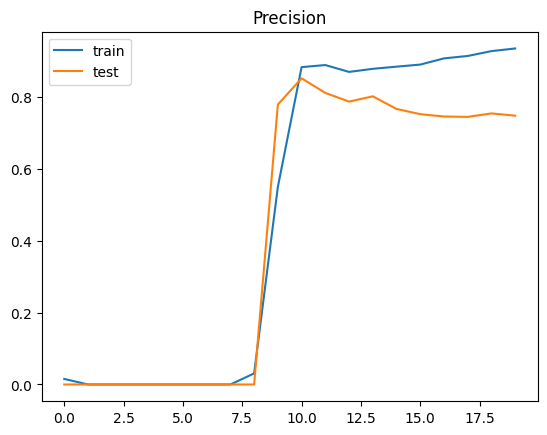

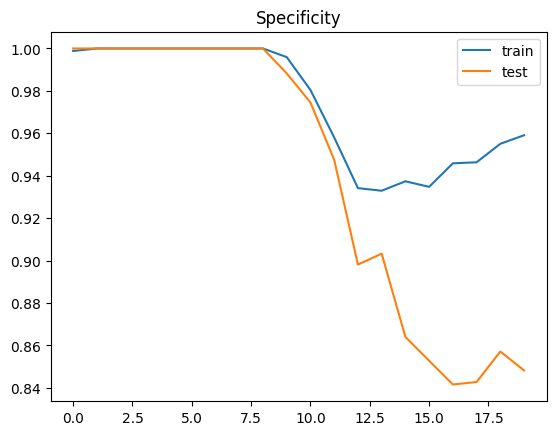

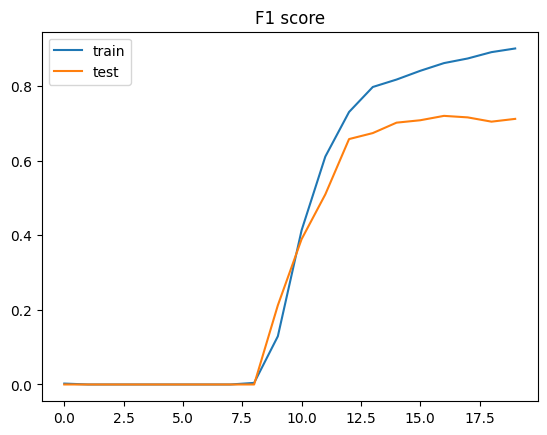

In [26]:
Y_probas = model.predict(X_val)
Y_pred = Y_probas.round().astype('int').flatten()
print(classification_report(Y_val, Y_pred))
plot_model_hist(history)

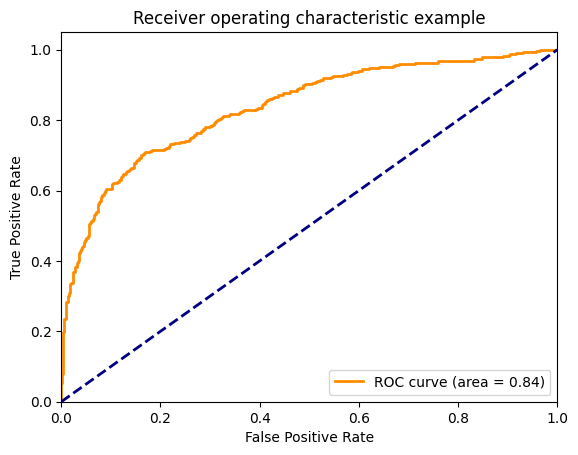

In [27]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_val, Y_probas)
roc_auc = auc(fpr_keras, tpr_keras)
plt.figure()
lw = 2
plt.plot(
    fpr_keras,
    tpr_keras,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

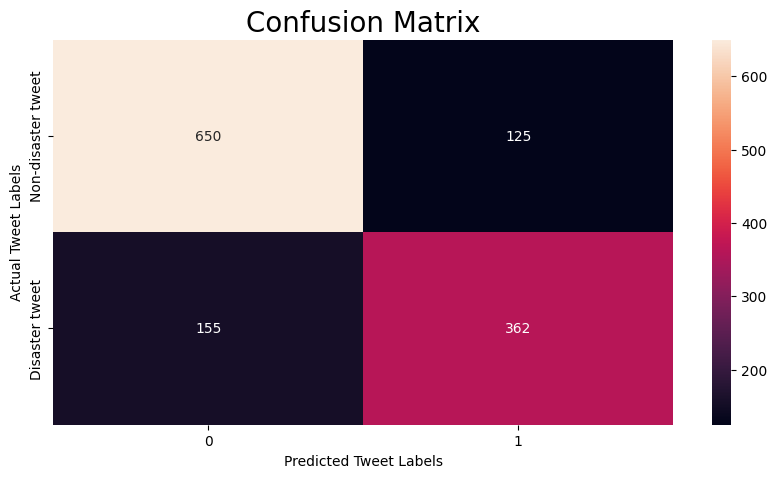

In [28]:
# Generate the confusion matrix that shows the true positive, true neative, false positive, and false negative labels

matrix = confusion_matrix(Y_val, Y_pred)
labels= ["Non-disaster tweet", "Disaster tweet"]
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix, annot=True, fmt="g", ax=ax)
plt.xlabel("Predicted Tweet Labels")
plt.ylabel("Actual Tweet Labels")
plt.title("Confusion Matrix", size=20)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.savefig('confusion_matrix.png')
plt.show()

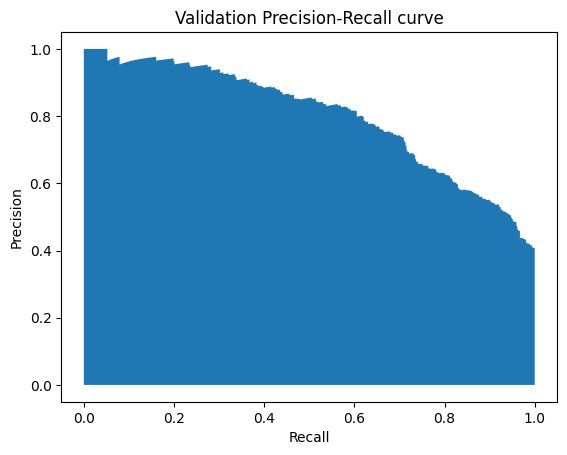

In [31]:
precision, recall, thresholds = precision_recall_curve(Y_val, Y_probas)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve");
plt.savefig("pr_curve.png")

Testing the model on example texts

In [32]:
example_texts = ['I got a tornado notification just now, take care everyone!!!',
                 'A truck containing 15 tonns of gas exploded in the middle of the city, costing lives of 3 firefighters',
                 'It has been raining heavily for the last 5 days',
                 'A 7.6 magnitude earthquake struck Japan on Jan. 1 around 2:10 a.m. EST (0710 GMT, or 4:10 p.m. local time in Japan)',
                 'Have a great weekends']
example_texts = [preprocess(x) for x in example_texts]
example_texts_emb = transform_text(tokenizer, example_texts)

example_predictions = model.predict(example_texts_emb)
print(np.column_stack((np.array(example_texts), np.array(example_predictions))))

1/1 [==============================] - 0s 59ms/step
[['got tornado notification take care everyone' '0.2183203']
 ['truck containing tonns gas exploded middle city costing life firefighter'
  '0.79829025']
 ['raining heavily last day' '0.08525524']
 ['magnitude earthquake struck japan jan around est gmt local time japan'
  '0.9400218']
 ['great weekend' '0.0774741']]


Testing the model on test dataframe

In [33]:
# Get embeddings for test dataframe
X_test = test['text']
X_test_cv = transform_text(tokenizer, X_test)

# Generate predictions
predictions = model.predict(X_test_cv)
predictions = predictions.round().astype('int').flatten()
predictions

102/102 [==============================] - 2s 23ms/step


array([1, 0, 1, ..., 1, 1, 1])

Preparing submission file for kaggle

In [34]:
submission_df = pd.read_csv('./Data/sample_submission.csv')
submission = pd.DataFrame({"id": submission_df['id'],
            "target":predictions})
submission.to_csv('submission.csv', index=False)

This submission scored 0.777 F1-score on kaggle submission.
Playing around with hyperparameters and model layers resulted in best F1-score of 0.79.
This configuration removed Convolutional layer and MaxPooling layer, keeping Embedding, LSTM and 2 hidden Dense layers along with output Sigmoid layer.